In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 919 kB 5.6 MB/s 
     |████████████████████████████████| 829 kB 41.4 MB/s 
     |████████████████████████████████| 636 kB 32.7 MB/s 
     |████████████████████████████████| 282 kB 28.7 MB/s 
     |████████████████████████████████| 119 kB 54.7 MB/s 
     |████████████████████████████████| 1.3 MB 34.0 MB/s 
     |████████████████████████████████| 294 kB 41.1 MB/s 
     |████████████████████████████████| 142 kB 68.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=d70399b5bba6880ede33ba0fcca570a59f5486ac41a1e4cf93e573c37ca725de
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [2]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
class Speedup(pl.LightningModule):
    def __init__(self,embed_dim=300,num_feats=1,hidden_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(embed_dim,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256,128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_dim+num_feats,32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Linear(32,1),
            nn.Tanh())
        
    def forward(self, e1, e2, s, l):
        diff = self.encoder(e1.float())-self.encoder(e2.float())
        diff = diff.view(diff.size()[0], -1)
        s = s.view(s.size()[0], -1)
        c = torch.cat((diff.float(),s.float()),1)
        out = self.out(c.float())
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        ir1, ir2, runtime_params, percent_speedup = train_batch
        y_hat = self(ir1,ir2,runtime_params)
        loss = F.mse_loss(y_hat, percent_speedup.float().unsqueeze(1))
        self.log('train_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = None):
        ir1, ir2, runtime_params,y = batch
        y_hat = self(ir1,ir2,runtime_params)
        return (y_hat,y)

    def validation_step(self, val_batch, batch_idx):
        ir1, ir2, runtime_params, percent_speedup = val_batch
        y_hat = self(ir1,ir2,runtime_params)
        loss = F.mse_loss(y_hat, percent_speedup.float().unsqueeze(1))
        self.log('val_loss', loss)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class PerformanceData(Dataset):
    """
        Class for creating iterator to kernel performance dataset
    """

    def __init__(self, ir1, ir2, input_size, percent_speedup):
        self.ir1=ir1
        self.ir2=ir2
        self.input_size=input_size
        self.local_size=local_size
        self.percent_speedup=percent_speedup

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.percent_speedup)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.ir1[index], self.ir2[index], self.input_size[index],self.local_size[index],self.percent_speedup[index]

In [ ]:
# data
df = pd.read_parquet('/content/drive/MyDrive/Deep learning for compiler opt/dataset.pq')
dataset = PerformanceData(torch.tensor(np.stack(df.ir1.to_list())),torch.tensor(np.stack(df.ir2.to_list())),torch.tensor(np.stack(df.globalSize.to_list())),torch.tensor(np.stack(df.localSize.to_list())),torch.tensor(np.stack(df.percent_speedup.to_list())))
train_data, test_data = random_split(dataset, [int(len(dataset)*.8), len(dataset)-int(len(dataset)*.8)], generator=torch.Generator().manual_seed(42))
train_data, val_data = random_split(train_data, [int(len(dataset)*.8), len(dataset)-int(len(dataset)*.8)], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_data, batch_size=32,num_workers=2)
test_loader = DataLoader(test_data, batch_size=32,num_workers=2)
val_loader = DataLoader(val_data, batch_size=32,num_workers=2)

In [ ]:
# model
model = Speedup(300,1,64)
# model = model.cuda()

# 1. Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback = ModelCheckpoint(monitor="val_loss")

# training
trainer = pl.Trainer(
    default_root_dir="/content/drive/MyDrive/Deep learning for compiler opt/",
    log_every_n_steps=20,   # set the logging frequency
    gpus=-1,                # use all GPUs
    auto_lr_find=True,
    max_epochs=50,           # number of epochs
    deterministic=True,     # keep it deterministic
    callbacks=[checkpoint_callback]
    )

trainer.fit(model, train_loader, val_loader)
checkpoint_callback.best_model_path

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
checkpoint_callback

''

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/Deep learning for compiler opt/lightning_logs"

In [ ]:
model = Speedup.load_from_checkpoint("/content/drive/MyDrive/Deep learning for compiler opt/lightning_logs/version_1/checkpoints/epoch=53-step=486269.ckpt")

In [ ]:
model

Speedup(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Sequential(
    (0): Linear(in_features=65, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Tanh()
  )
)

In [ ]:
r = trainer.predict(model,test_loader)

Predicting: 1474it [00:00, ?it/s]

In [ ]:
def get_df(l):
  df = pd.DataFrame(columns=['predicted','actual'])
  for i in l:
    er = pd.DataFrame(columns=['actual','predicted'])
    er.actual = i[1].numpy()
    er.predicted = i[0].view(i[0].size()[0]).numpy()
    df = df.append(er,ignore_index=True)
  return df

In [ ]:
er_ds = get_df(r)

In [ ]:
er_ds

,predicted,actual
0,0.042055,0.000940
1,-0.272076,-0.313191
2,-0.520379,-0.561493
3,-0.395834,-0.436948
4,0.041468,0.000354
...,...,...
72032,0.035149,-0.000401
72033,-0.189063,-0.224614
72034,-0.661427,-0.696978
72035,0.035719,0.000168


In [ ]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(er_ds.actual, er_ds.predicted))
print(mean_squared_error(er_ds.actual, er_ds.predicted,squared=False))

0.052132491919954636
0.22832540795968073


In [ ]:
from sklearn.metrics import max_error
max_error(er_ds.actual, er_ds.predicted)

0.6842826008796693

In [ ]:
from sklearn.metrics import r2_score
r2_score(er_ds.actual, er_ds.predicted)

0.5290109902531515

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score # (y_true, y_score, *) Compute average precision (AP) from prediction scores.
from sklearn.metrics import f1_score # (y_true, y_pred, *[, labels, …]) Compute the F1 score, also known as balanced F-score or F-measure.
from sklearn.metrics import fbeta_score # (y_true, y_pred, *, beta[, …]) Compute the F-beta score.
from sklearn.metrics import precision_recall_curve # (y_true, probas_pred, *) Compute precision-recall pairs for different probability thresholds.
from sklearn.metrics import precision_recall_fscore_support # (y_true, …) Compute precision, recall, F-measure and support for each class.
from sklearn.metrics import precision_score # (y_true, y_pred, *[, labels, …]) Compute the precision.
from sklearn.metrics import recall_score # (y_true, y_pred, *[, labels, …]) Compute the recall.
from matplotlib import pyplot as plt

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\n\n\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
import seaborn as sns

In [ ]:
y_pred = er_ds.predicted>0
y_true = er_ds.actual>0

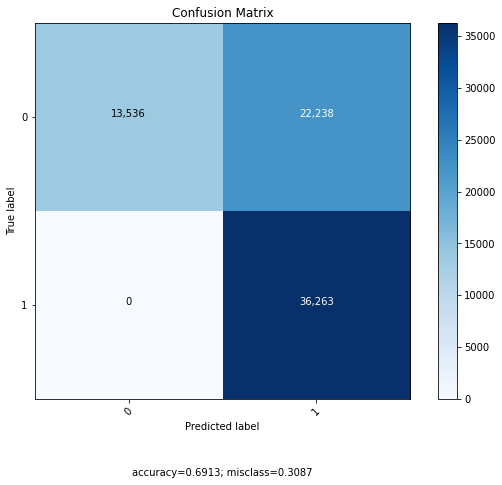

In [ ]:
cm = confusion_matrix(y_pred=y_pred,y_true = y_true)
tn, fp, fn, tp = cm.ravel()
plot_confusion_matrix(cm=cm, normalize= False,
                      target_names = [0,1],
                      title        = "Confusion Matrix")

In [ ]:
(tn, fp, fn, tp)

(13536, 22238, 0, 36263)

In [ ]:
fp/sum((tn, fp))

0.6216246435959076

In [ ]:
accuracy_score(y_pred=y_pred,y_true = y_true)

0.6912975276593972

In [ ]:
average_precision_score(y_true, y_pred)

0.6198697458163108

In [ ]:
precision_score(y_true, y_pred)

0.6198697458163108

In [ ]:
recall_score(y_true, y_pred)

1.0

In [ ]:
precision_recall_fscore_support(y_true,y_pred)

(array([1.        , 0.61986975]),
 array([0.37837536, 1.        ]),
 array([0.54901643, 0.76533283]),
 array([35774, 36263]))

In [ ]:
fbeta_score(y_true, y_pred,beta=0.5)

0.6708736175707727

In [ ]:
f1_score(y_true, y_pred)

0.7653328268118694